In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
from matplotlib import colors
import matplotlib.cm as cm
from matplotlib import rcParams

params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium',
         'font.family': 'sans-serif',
         'font.sans-serif': 'Arial',
         'font.size': 12,
         'text.usetex': True}
rcParams.update(params)

In [22]:
class s():
    #u1 is cells - 2d
    #u2 is matrix - 1d
    def __init__(self,Nx, Ny, dt, tmax, Dx=1, Dy=1, r=1, umax=1, deg=1, v=1, xmin=0, xmax=1, ymin=0, ymax=1):
        self.Nx = Nx
        self.Ny = Ny
        self.dt = dt
        self.tmax = tmax
        self.Dx = Dx
        self.Dy = Dy
        self.r = r
        self.umax = umax
        self.deg = deg        
        self.v = v
        

        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        
        self.dx = (self.xmax - self.xmin) / self.Nx
        self.dy = (self.ymax - self.ymin) / self.Ny
        self.spx = np.linspace(self.xmin, self.xmax, self.Nx + 1)
        self.spy = np.linspace(self.ymin, self.ymax, self.Ny + 1)
        
        # self.dx=1/self.Nx; 
        # self.dy=1/self.Ny;
        # self.spx=np.linspace(0,self.Nx,self.Nx+1)*self.dx;
        # self.spy=np.linspace(0,self.Ny,self.Ny+1)*self.dy;
        self.ymean=self.meanval(self.spy);
        
        self.tim=np.arange(0,self.tmax+self.dt, self.dt); #was previously tmax+1 but unsure why - think on it now whilst do
    
    def set_ICs(self, init_u1, init_u2):
        #initialise density
        self.u1 = [init_u1]
        self.u2 = [init_u2]
        self.u_ex = [np.concatenate([init_u1.ravel(),init_u2])] # flatten the 2d array, followed by the 1d array (matrix)
        
    def meanval(self,z): #computes the mean value of the grid as half of the sum of the edges
        y=0.5*(z[:-1]+z[1:]);
        return y
       
    def splitter(self,u_expanded): #split u into arrays for each x component 
        u1 = u_expanded[:(self.Nx+1)*self.Ny].reshape((self.Nx+1,self.Ny))
        u2 = u_expanded[(self.Nx+1)*self.Ny:]
        return u1, u2
    
    def fun_local_mass(self, Usol): #computes the local mass of the solution
        return np.sum(Usol,axis=1) #self.hz*np.sum(Usol,axis=1) #computes actual mass not just total denisty which is what it currently does

    def set_diffusion_fct_y(self, diff_fct_y):
        self.diff_fct = diff_fct_y[0]
        
        self.diff_fct_names=[]
        for i in diff_fct_y:
            self.diff_fct_names.append(i.__name__)
            
    def set_advection_fct_y(self, adv_fct_y):
        self.adv_fct = adv_fct_y[0]
        
        self.adv_fct_names=[]
        for i in adv_fct_y:
            self.adv_fct_names.append(i.__name__)
            
    def set_reaction_fct(self, reac_fct):
        self.reac_fct = reac_fct[0]
        
        self.reac_fct_names=[]
        for i in reac_fct:
            self.reac_fct_names.append(i.__name__)
    
    def disc_1D_inhomogeneous_x(self, f, D):
        dx = self.dx
        lap = np.zeros(f.shape)
        # Debugging print statements, commented out for clarity
        # print(D.shape, f.shape, lap.shape)
        # print(D[1:].shape, D[:-1].shape, D[1:][:, None].shape, f[2:, :].shape, f[1:-1, :].shape, f[:-2, :].shape,)

        # Adjusted for a 1D D along y
        lap[1:-1, :] = (
            ((D[2:] + D[1:-1])[:, None] * (f[2:, :] - f[1:-1, :]) -
            (D[1:-1] + D[:-2])[:, None] * (f[1:-1, :] - f[:-2, :])) / (2*dx**2)
        )

        # Boundary conditions
        lap[0, :] = (D[1] + D[0]) * (f[1, :] - f[0, :]) / (2*dx**2)
        lap[-1, :] = (D[-1] + D[-2]) * (f[-2, :] - f[-1, :]) / (2*dx**2)

        return lap

    def laplacian_y(self, f): # laplacian of density in x direction only
        dy = self.dy
        lap = np.zeros(f.shape) # zero array of same shape as f
        lap[:,1:-1] = (f[:,2:] - 2*f[:,1:-1] + f[:,:-2])/dy**2 # laplacian of f in inner points
        lap[:,0] = (f[:,1] - f[:,0])/dy**2
        lap[:,-1] = (f[:,-2] - f[:,-1])/dy**2
        return lap
  
    def laplacian_x(self, f): # laplacian of density in y direction only
        dx = self.dx
        lap = np.zeros(f.shape) # zero array of same shape as f
        lap[1:-1, :] = (f[2:, :] - 2*f[1:-1, :] + f[:-2,:])/dx**2 # laplacian of f in inner points
        lap[0, :] = (f[1, :] - f[0, :])/dx**2
        lap[-1, :] = (f[-2, :] - f[-1, :])/dx**2
        return lap
    
    def limiter(self, r):
        # Vectorized limiters
        delta = 2
        K = 1. / 3 + 2. / 3. * r
        y = np.maximum(0, np.minimum(np.minimum(2 * r, delta), K))
        y[np.logical_or(np.isinf(r), np.isnan(r))] = 0
        return y
    
    def prol(self,z,KKrho,m): #calculating proliferation rate
        """
        Parameters
        ----------
        z : vector
            phenotypic coordinate.
        rho : float
            local total cell number.
        m : float
            ECM density.
        par : dictionary
            dictionary containing the list of parameter involved in the model.
        Returns
        -------
        y : vector
        proliferation rate as a function of the phenotypic variable

        """
        
        vf_coefficient = (1 - (rho+m)/self.umax)

        y = self.r*vf_coefficient
        return y
    
    def dyz(self, p1, p2):
        np.seterr(divide='ignore', invalid='ignore')

        # Vectorized computation of velocity, second order difference, and limiters
        vel = self.adv_fct(p1, p2, self.spy)

        u = p1        
        r = np.diff(u[:, 1:]) / np.diff(u[:, :-1])
        rp = np.insert(r, 0, 0, axis=1)
        rm = np.append(1 / r, np.zeros((r.shape[0], 1)), axis=1)
        
        phip = self.limiter(rp)
        phim = self.limiter(rm)
        
        fluxp = u[:, :-1] + 0.5 * phip * np.diff(u, axis=1)
        fluxm = u[:, 1:] + 0.5 * phim * np.diff(u[:, ::-1], axis=1)[:, ::-1]
        #print('vel:')
        #print(vel.shape)
        T = np.maximum(0, vel[:, 1:-1]) * fluxp + np.minimum(0, vel[:, 1:-1]) * fluxm
        # #print('check')
        # transport = np.diff(T, axis=1, prepend=T[:, 0:1], append=-T[:, -1:]) / self.dy
        
        transport = np.insert(np.diff(T, axis=1), 0, T[:, 0], axis=1)
        transport = np.append(transport, -T[:, -1:], axis=1) / self.dy

        return transport
    
    def diff_y(self, phen, dens, ecm):
        return self.diff_fct(phen, dens, ecm)
    
    def adv_y(self, x, y, z):
        return self.adv_fct(x, y, z)
    
    def reac(self, u1, u2):
        return self.reac_fct(u1, u2)
    
    def dpdt(self, t, p_expanded):
        p1, p2 = self.splitter(p_expanded)
        h1 = self.laplacian_x(p1)
        
        diff_1 = h1 + self.reac(p1, p2) 
        
        # Reaction term for ECM degradation by cells
        deg_int = self.fun_local_mass(p1)
        diff_2 = -self.deg*p2*deg_int
        
        return np.concatenate([diff_1.ravel(), diff_2])
    
    def solve(self):
        print('Maximum time = %.2f' % self.tmax)
        
        solODE = ode(self.dpdt).set_integrator('dopri5')
        solODE.set_initial_value(self.u_ex[0],0)
        
        t = 0
        k = 0
        while t < self.tmax:
            print('t = %.2f'% t,end = '\r')
            t += self.dt
            k += 1
            
            u_ex_next = solODE.integrate(t)
            p1, p2 = self.splitter(u_ex_next)
            self.u1.append(p1)
            self.u2.append(p2)
        t_end = t + self.dt
        print('Finished: t = %.2f'% t_end)
        return self.u1, self.u2    

/var/folders/vb/cz4pzhrx05vfycqcv7fzb8_00000gn/T/ipykernel_62587/856531623.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


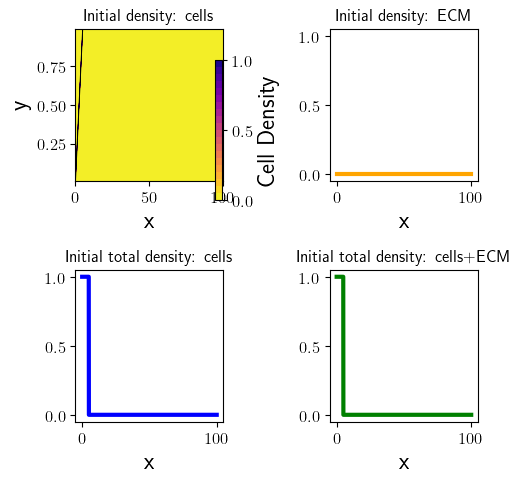

In [23]:
# Define your parameters
Nx=1000
Ny=50

#Model params - ND model - set these to 0
Dx=1
r=1
umax=1
deg=0 #no ECM degradation

#no phenotypic drift
Dy = 0
v= 0 #default to start

dt=0.1
tmax=50

xmin=0
xmax=100
ymin=0
ymax=1

dens_i1 = 1
dens_i2 = 0


solver = s(Nx, Ny, dt, tmax, Dx, Dy, r, umax, deg, v, xmin, xmax, ymin, ymax)

# Assuming solver.zmean and solver.spx are defined
[Z, X] = np.meshgrid(solver.ymean, solver.spx)


# Define the initial condition
u0 = np.zeros_like(Z)
for i in range(len(solver.ymean)):
    u0[i,i]=dens_i1

# Normalize u0 so that the sum of each column is <= 1
column_sums = solver.fun_local_mass(u0)
nc = np.max(column_sums)
u0_normalized = u0 / nc

init_rho_1 = u0_normalized

# Initialize rho2 as a 1D array, since it varies only in the x direction
init_rho_2 = dens_i2 * np.ones(len(solver.spx))
# Subtract the initial density of cells from ECM density where cells are present
init_rho_1_sum = solver.fun_local_mass(init_rho_1)
for j in range(len(solver.spx)):
    if init_rho_1_sum[j] > 0.001:
    #np.any(init_rho_1[:, j] > 10e-2):
        init_rho_2[j] = 0
        
init_rho_1_max = np.max(init_rho_1)

# Plotting the initial conditions
fig, ax = plt.subplots(2, 2, figsize=(5, 5))

#Calculate the sum of the cell densities
init_rho_1_sum = solver.fun_local_mass(init_rho_1)

# Cell density
c1 = ax[0,0].contourf(X, Z, init_rho_1, levels=np.linspace(0, init_rho_1_max, 21), cmap='plasma_r')
ax[0,0].contour(X, Z, init_rho_1, [0], linewidths=0.5, colors='k') 
ax[0,0].set_title('Initial density: cells')
ax[0,0].set_xlabel('x')
ax[0,0].set_ylabel('y')

# ECM density
ax[0,1].plot(solver.spx, init_rho_2, color='orange', linewidth=3)
ax[0,1].fill_between(solver.spx, 0, init_rho_2, color='orange', alpha=0.3)
ax[0,1].set_title('Initial density: ECM')
ax[0,1].set_xlabel('x')
ax[0,1].set_ylim(-0.05, umax+0.05)

#sum of cel  densities to check 
ax[1,0].plot(solver.spx, init_rho_1_sum, color='blue', linewidth=3)
ax[1,0].set_title('Initial total density: cells')
ax[1,0].set_xlabel('x')
ax[1,0].set_ylim(-0.05, umax+0.05)

#sum of densities to check 
ax[1,1].plot(solver.spx, init_rho_2+init_rho_1_sum, color='green', linewidth=3)
ax[1,1].set_title('Initial total density: cells+ECM')
ax[1,1].set_xlabel('x')
ax[1,1].set_ylim(-0.05, umax+0.05)

cbar = fig.colorbar(c1, ax=[ax[0,0], ax[0,1]], location='right', anchor=(0.4,0.75), label = r'Cell Density', fraction=1, shrink=0.8) #'difference in numerically estimated wave speed')
cbar.set_ticks([0, init_rho_1_max/2, init_rho_1_max])

plt.tight_layout()
plt.show()


In [24]:
def KPP_whole(x, y):
    return x*(1-solver.fun_local_mass(x)[:, np.newaxis])
def Allee_whole(x, y):
    return x*(1-solver.fun_local_mass(x)[:, np.newaxis])*(solver.fun_local_mass(x)[:, np.newaxis]-p)

/var/folders/vb/cz4pzhrx05vfycqcv7fzb8_00000gn/T/ipykernel_62587/2990785037.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', Ny)  # Create a colormap with the number of phenotypes


Maximum time = 40.00
Finished: t = 40.10
Maximum time = 120.00
Finished: t = 120.20
Maximum time = 1000.00
Finished: t = 1000.10


/var/folders/vb/cz4pzhrx05vfycqcv7fzb8_00000gn/T/ipykernel_62587/2990785037.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to make room for the color bar


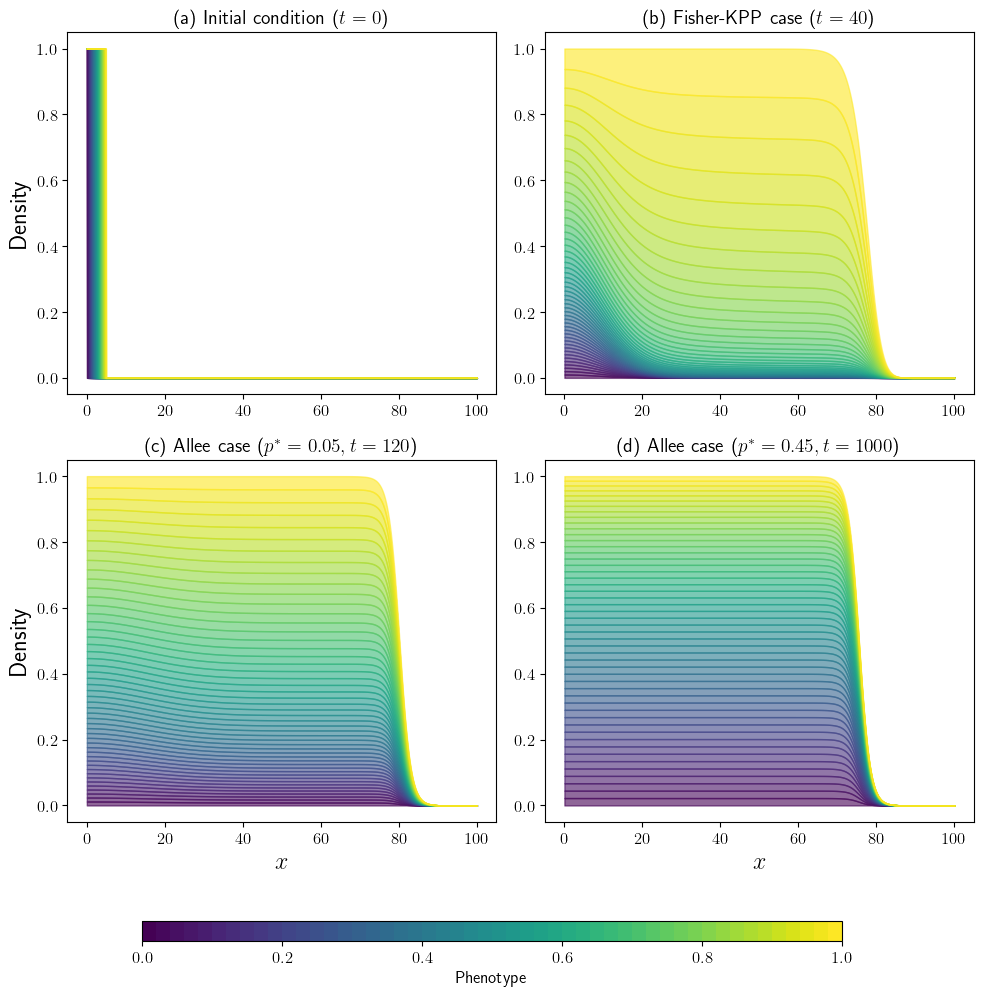

In [25]:
tmaxes = [40, 120, 1000]
dt = 0.1

funcs = [KPP_whole, Allee_whole, Allee_whole]
ps = [0, 0.05, 0.45]

mean_y_values = []

plot_pts = tmaxes  # times to plot
indexes = [int(pt/dt) for pt in plot_pts]  # indexes for plotting times

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.flatten()  # Flatten to easily loop over

# Create a colormap
cmap = cm.get_cmap('viridis', Ny)  # Create a colormap with the number of phenotypes
norm = colors.Normalize(vmin=0, vmax=1)  # Normalize the color bar to range between 0 and 1

for i in range(len(funcs)):
    j = i + 1
    solver = s(Nx, Ny, dt, tmaxes[i], Dx, Dy, r, umax, deg, v, xmin, xmax, ymin, ymax)
    p = ps[i]

    solver.set_ICs(init_rho_1, init_rho_2)
    solver.set_reaction_fct([funcs[i]])
    rho1, rho2 = solver.solve()

    rho1_array = np.array(rho1)
    rho2_array = np.array(rho2)  # Apply the condition and create new variables

    rho1_new = np.where(rho1_array < 1e-5, 0, rho1_array)
    rho2_new = np.where(rho2_array < 1e-5, 0, rho2_array)  # Calculate the mean y value at each x point

    cumulative_density = np.zeros_like(solver.spx)
    for k in range(Ny):  # Loop over phenotypes
        color = cmap(k / (Ny - 1))
        ax[j].fill_between(solver.spx, cumulative_density, cumulative_density + rho1_new[indexes[i], :, k], color=color, alpha=0.6)
        cumulative_density += rho1_new[indexes[i], :, k]

    ax[j].set_title(f't= {plot_pts[i]}', fontsize=14)
    if j == 2:
        ax[j].set_xlabel('$x$')
        ax[j].set_ylabel('Density')
    elif j == 3:
        ax[j].set_xlabel('$x$')  
    # ax[j].set_xlabel('$x$')
    # ax[j].set_ylabel('Density')

# Add a single color bar to the figure
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Phenotype', fontsize=12)

cumulative_density = np.zeros_like(solver.spx)
ax[0].set_ylabel('Density')  # label y axis for rho1
# ax[0].set_xlabel('$x$')
ax[0].set_title(f't= 0', fontsize=14)
for k in range(Ny):  # Loop over phenotypes
        color = cmap(k / (Ny - 1))
        ax[0].fill_between(solver.spx, cumulative_density, cumulative_density + rho1_new[0, :, k], color=color, alpha=0.6)
        cumulative_density += rho1_new[0, :, k]

titles = ['(a) Initial condition ($t=0$)', '(b) Fisher-KPP case ($t=40$)', '(c) Allee case ($p^*=0.05, t=120$)', '(d) Allee case ($p^*=0.45, t=1000$)']
for i in range(len(titles)):
    ax[i].set_title(titles[i], fontsize=14)

plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to make room for the color bar

plt.savefig('figs/allee_kpp_comparison.pdf', format = 'pdf', dpi=300, bbox_inches='tight')  
plt.savefig('figs/allee_kpp_comparison.svg', format = 'svg', dpi=300, bbox_inches='tight')
plt.savefig('figs/allee_kpp_comparison.png', format = 'png', dpi=300, bbox_inches='tight')  
plt.show()